# TF-IDF for Book Tags
Term Frequency - Inverse Document Frequency (TF-IDF) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

### import requirements

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
import string
import random
import requests
from collections import Counter
from PIL import Image

In [2]:
import sklearn
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.utils import plot_model
from keras.layers import Flatten, Embedding
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, Dot
from keras.optimizers import Adam

### load dataset

my original dataset

In [3]:
df_ratings = pd.read_csv('books/Ratings.csv')
df_ratings.columns = ['uid', 'isbn', 'rating']
df_ratings.head(3)

,uid,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [4]:
# df_books = pd.read_csv('books/Books.csv')
# df_books.head(3)

In [5]:
# df_books.shape

the dataset with book tags i want to merge with

source: [Good Reads dataset](https://www.kaggle.com/zygmunt/goodbooks-10k?select=book_tags.csv) obtained from Kaggle

In [6]:
# books_df = pd.read_csv('books/books_10k.csv')
# books_df.head(3)

In [7]:
# booktags_df = pd.read_csv('books/book_tags.csv')
# booktags_df.head(3)

In [8]:
# tags_df = pd.read_csv('books/tags.csv')
# tags_df.head(3)

In [9]:
# booktags_df = booktags_df.merge(tags_df, how='outer', on='tag_id')
# booktags_df.head(3)

In [10]:
# booktags_df = booktags_df.merge(books_df, how='outer', 
#                                 left_on='goodreads_book_id',
#                                 right_on='book_id')
# booktags_df.head(3)

In [11]:
# booktags_df = booktags_df[['tag_id', 'tag_name', 'isbn']]

In [12]:
# booktags_df.shape

merge the two datasets!

In [13]:
# df_books = df_books.merge(booktags_df, left_on='ISBN', right_on='isbn')
# df_books.head(3)

In [14]:
# df_books.shape

In [15]:
# df_books = df_books[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'tag_name']]
# df_books.columns = ['isbn', 'title', 'author', 'year', 'publisher', 'tag_name']
# df_books.head(3)

In [16]:
#df_books.to_csv('books/Books_tags.csv')

In [17]:
booktags_df = pd.read_csv('books/Books_tags.csv', index_col=0)
booktags_df.shape

(39800, 6)

In [18]:
df_books = booktags_df.drop_duplicates(subset=['isbn'])
df_books.shape

(398, 6)

In [19]:
num_tags = len(set(booktags_df['tag_name']))
num_books = len(set(booktags_df['isbn']))
num_auths = len(set(booktags_df['author']))
print(f'There are {num_books} books from {num_auths} authors \
labelled with {num_tags} tags in the dataset.')

There are 398 books from 346 authors labelled with 6096 tags in the dataset.


In [20]:
booktags_df

,isbn,title,author,year,publisher,tag_name
0,067976397X,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,to-read
1,067976397X,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,favorites
2,067976397X,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,currently-reading
3,067976397X,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,fiction
4,067976397X,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,books-i-own
...,...,...,...,...,...,...
39795,1573226068,Drown,Junot Diaz,1997,Riverhead Books,dominican-republic
39796,1573226068,Drown,Junot Diaz,1997,Riverhead Books,latinx
39797,1573226068,Drown,Junot Diaz,1997,Riverhead Books,hispanic
39798,1573226068,Drown,Junot Diaz,1997,Riverhead Books,dominican


## calculate similarity

In [21]:
isbn1 = df_books.loc[df_books['isbn']=='006441034X']
print(isbn1['title'])

15700    Howl's Moving Castle
Name: title, dtype: object


In [22]:
indices = pd.Series(df_books.index, index=df_books['title'])

calculate similarities between title

In [23]:
tf_title = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),
                          min_df=0, stop_words='english')

tfidf_matrix_title = tf_title.fit_transform(booktags_df['title'])

cosine_sim_title = linear_kernel(tfidf_matrix_title, tfidf_matrix_title)

In [24]:
#cosine_sim_title

In [25]:
def titles_recom(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_title[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [26]:
titles_recom('Howl\'s Moving Castle', 10)

0                           Corelli's Mandolin : A Novel
100                                  Atonement : A Novel
200             Preludes and Nocturnes (Sandman, Book 1)
300        The League of Extraordinary Gentlemen, Vol. 1
400                                             Affinity
500    Prozac Nation: Young and Depressed in America ...
600                                             The Firm
700                                 The Tortilla Curtain
800                                         Four Blondes
900                                     Chasing the Dime
Name: title, dtype: object

calculate similarities between authors

In [27]:
tf_auth = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),
                          min_df=0, stop_words='english')

tfidf_matrix_auth = tf_auth.fit_transform(booktags_df['author'])

cosine_sim_auth = linear_kernel(tfidf_matrix_auth, tfidf_matrix_auth)

In [28]:
#cosine_sim_auth

In [29]:
def authors_recom(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_auth[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [30]:
authors_recom('Howl\'s Moving Castle', 10)

0                           Corelli's Mandolin : A Novel
100                                  Atonement : A Novel
200             Preludes and Nocturnes (Sandman, Book 1)
300        The League of Extraordinary Gentlemen, Vol. 1
400                                             Affinity
500    Prozac Nation: Young and Depressed in America ...
600                                             The Firm
700                                 The Tortilla Curtain
800                                         Four Blondes
900                                     Chasing the Dime
Name: title, dtype: object

calculate similarities between publishers

In [31]:
tf_pub = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),
                          min_df=0, stop_words='english')

tfidf_matrix_pub = tf_pub.fit_transform(booktags_df['publisher'])

cosine_sim_pub = linear_kernel(tfidf_matrix_pub, tfidf_matrix_pub)

In [32]:
#cosine_sim_pub

In [33]:
def pubs_recom(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_pub[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[:n+1]

In [34]:
pubs_recom('Howl\'s Moving Castle', 10)

7200     Ramona and Her Mother (Ramona Quimby (Paperback))
10300            The Midwife's Apprentice (Trophy Newbery)
11200                                  Good Night, Mr. Tom
15700                                 Howl's Moving Castle
28100            A Bargain for Frances (I Can Read Book 2)
30000             Chicken Soup with Rice: A Book of Months
0                             Corelli's Mandolin : A Novel
100                                    Atonement : A Novel
200               Preludes and Nocturnes (Sandman, Book 1)
300          The League of Extraordinary Gentlemen, Vol. 1
400                                               Affinity
Name: title, dtype: object

calculate similarities between book tags

In [35]:
tf_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),
                         min_df=0, stop_words='english')

tfidf_matrix_tag = tf_tag.fit_transform(booktags_df['tag_name'])

cosine_sim_tag = linear_kernel(tfidf_matrix_tag, tfidf_matrix_tag)

In [36]:
#cosine_sim_tag

In [37]:
def tags_recom(title, n):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_tag[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[:n]

In [38]:
tags_recom('Howl\'s Moving Castle', 10)

0                           Corelli's Mandolin : A Novel
100                                  Atonement : A Novel
200             Preludes and Nocturnes (Sandman, Book 1)
300        The League of Extraordinary Gentlemen, Vol. 1
400                                             Affinity
500    Prozac Nation: Young and Depressed in America ...
600                                             The Firm
700                                 The Tortilla Curtain
800                                         Four Blondes
900                                     Chasing the Dime
Name: title, dtype: object

try title and tags together similarity

In [39]:
booktags_df['combined_title_tag'] = pd.Series(
    booktags_df[['title','tag_name']].fillna('').values.tolist()).str.join(' ')

In [40]:
tf_combined_title_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2)
                                       ,min_df=0, stop_words='english')

tfidf_matrix_combined_title_tag = tf_combined_title_tag.fit_transform(booktags_df['combined_title_tag'])

cosine_sim_combined_title_tag = linear_kernel(tfidf_matrix_combined_title_tag, tfidf_matrix_combined_title_tag)

In [41]:
def combined_title_tag_recom(title, n):    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_combined_title_tag[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [42]:
combined_title_tag_recom('Howl\'s Moving Castle', 10)

28100    A Bargain for Frances (I Can Read Book 2)
33300                           The Fire Next Time
1600                                         Speak
10400                             The Power of One
4500                                     The Beach
34400                                 On the Beach
8500                               How to be good.
28200                                    The River
30200                           Something Borrowed
16900                                 Just for You
Name: title, dtype: object

try author and tags together similarity

In [43]:
booktags_df['combined_auth_tag'] = pd.Series(
    booktags_df[['author','tag_name']].fillna('').values.tolist()).str.join(' ')

In [44]:
tf_combined_auth_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2)
                                       ,min_df=0, stop_words='english')

tfidf_matrix_combined_auth_tag = tf_combined_auth_tag.fit_transform(booktags_df['combined_auth_tag'])

cosine_sim_combined_auth_tag = linear_kernel(tfidf_matrix_combined_auth_tag, tfidf_matrix_combined_auth_tag)

In [45]:
def combined_auth_tag_recom(title, n):    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_combined_auth_tag[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [46]:
combined_auth_tag_recom('Howl\'s Moving Castle', 10)

18400    Alive : The Story of the Andes Survivors (Avon...
26500    Vampire Diaries #2: The Struggle (The Vampire ...
5800     Sojourn (Forgotten Realms Novel: Dark Elf Tril...
14200    Streams of Silver (Forgotten Realms: The Icewi...
20200    The Icewind Dale Trilogy Collector's Edition (...
23700    Starless Night (Forgotten Realms:  Legacy of t...
8600                                         Chobits Vol.1
14900            Cardcaptor Sakura, Master of the Clow (1)
38400    Cardcaptor Sakura (Cardcaptor Sakura Authentic...
25600                       The Waste Land and Other Poems
Name: title, dtype: object

try publisher and tags together similarity

In [47]:
booktags_df['combined_pub_tag'] = pd.Series(
    booktags_df[['publisher','tag_name']].fillna('').values.tolist()).str.join(' ')

In [48]:
tf_combined_pub_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2)
                                       ,min_df=0, stop_words='english')

tfidf_matrix_combined_pub_tag = tf_combined_pub_tag.fit_transform(booktags_df['combined_pub_tag'])

cosine_sim_combined_pub_tag = linear_kernel(tfidf_matrix_combined_pub_tag, tfidf_matrix_combined_pub_tag)

In [49]:
def combined_pub_tag_recom(title, n):    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_combined_pub_tag[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [50]:
combined_pub_tag_recom('Howl\'s Moving Castle', 10)

10300            The Midwife's Apprentice (Trophy Newbery)
11200                                  Good Night, Mr. Tom
15700                                 Howl's Moving Castle
28100            A Bargain for Frances (I Can Read Book 2)
30000             Chicken Soup with Rice: A Book of Months
27600        The Dogs of Riga (Vintage Crime/Black Lizard)
29000         The Fifth Woman (Vintage Crime/Black Lizard)
700                                   The Tortilla Curtain
3400     The Women of Brewster Place (Penguin Contempor...
5000                                 Bridget Jones's Diary
Name: title, dtype: object

try everything together

In [51]:
booktags_df['combined_title_auth_pub_tag'] = pd.Series(
    booktags_df[['title', 'author', 'publisher', 'tag_name']].fillna('').values.tolist()).str.join(' ')

In [52]:
tf_combined_title_auth_pub_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2)
                                       ,min_df=0, stop_words='english')

tfidf_matrix_combined_title_auth_pub_tag = tf_combined_title_auth_pub_tag.fit_transform(
    booktags_df['combined_title_auth_pub_tag'])

cosine_sim_combined_title_auth_pub_tag = linear_kernel(
    tfidf_matrix_combined_title_auth_pub_tag, tfidf_matrix_combined_title_auth_pub_tag)

In [53]:
def combined_title_auth_pub_tag_recom(title, n):    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim_combined_title_auth_pub_tag[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    book_indices = [i[0] for i in sim_scores]
    return booktags_df.loc[book_indices]['title'].drop_duplicates()[1:n+1]

In [54]:
combined_title_auth_pub_tag_recom('Howl\'s Moving Castle', 10)

28100            A Bargain for Frances (I Can Read Book 2)
11200                                  Good Night, Mr. Tom
10300            The Midwife's Apprentice (Trophy Newbery)
30000             Chicken Soup with Rice: A Book of Months
7200     Ramona and Her Mother (Ramona Quimby (Paperback))
5000                                 Bridget Jones's Diary
18400    Alive : The Story of the Andes Survivors (Avon...
22900    How to Read Literature Like a Professor : A Li...
19700                                             Songbook
9800                                           Fingersmith
Name: title, dtype: object

In [90]:
df_books['combined_title_auth_pub_tag'] = pd.Series(
    df_books[['title', 'author', 'publisher', 'tag_name']].fillna('').values.tolist()).str.join(' ')
df_books['combined_title_auth_pub_tag'] = df_books['combined_title_auth_pub_tag'].fillna('')

tf_combined_title_auth_pub_tag = TfidfVectorizer(analyzer='word',ngram_range=(1, 2)
                                       ,min_df=0, stop_words='english')
tfidf_matrix_combined_title_auth_pub_tag = tf_combined_title_auth_pub_tag.fit_transform(
    df_books['combined_title_auth_pub_tag'])
cosine_sim_combined_title_auth_pub_tag = linear_kernel(
    tfidf_matrix_combined_title_auth_pub_tag, tfidf_matrix_combined_title_auth_pub_tag)

combined_title_auth_pub_tagSim =pd.DataFrame(cosine_sim_combined_title_auth_pub_tag, 
                                             columns=df_books['title'], index=df_books['title'])
combined_title_auth_pub_tagSim.head(3)

title,Corelli's Mandolin : A Novel,Atonement : A Novel,"Preludes and Nocturnes (Sandman, Book 1)","The League of Extraordinary Gentlemen, Vol. 1",Affinity,Prozac Nation: Young and Depressed in America : A Memoir,The Firm,The Tortilla Curtain,Four Blondes,Chasing the Dime,...,Shantaram,The Taming of the Shrew (New Folger Library Shakespeare),Around the World in 80 Days (Penguin Classics),The Magic Faraway Tree,"First Shot, Last Call (100 Bullets, Book 1)",The Watsons Go to Birmingham 1963,An Ideal Husband (Dover Thrift Editions),Leadership and Self Deception: Getting Out of the Box,Katherine,Drown
title,,,,,,,,,,,,,,,,,,,,,
Corelli's Mandolin : A Novel,1.000000,0.118320,0.069598,0.050275,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Atonement : A Novel,0.118320,1.000000,0.064657,0.046706,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Preludes and Nocturnes (Sandman, Book 1)",0.069598,0.064657,1.000000,0.060412,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


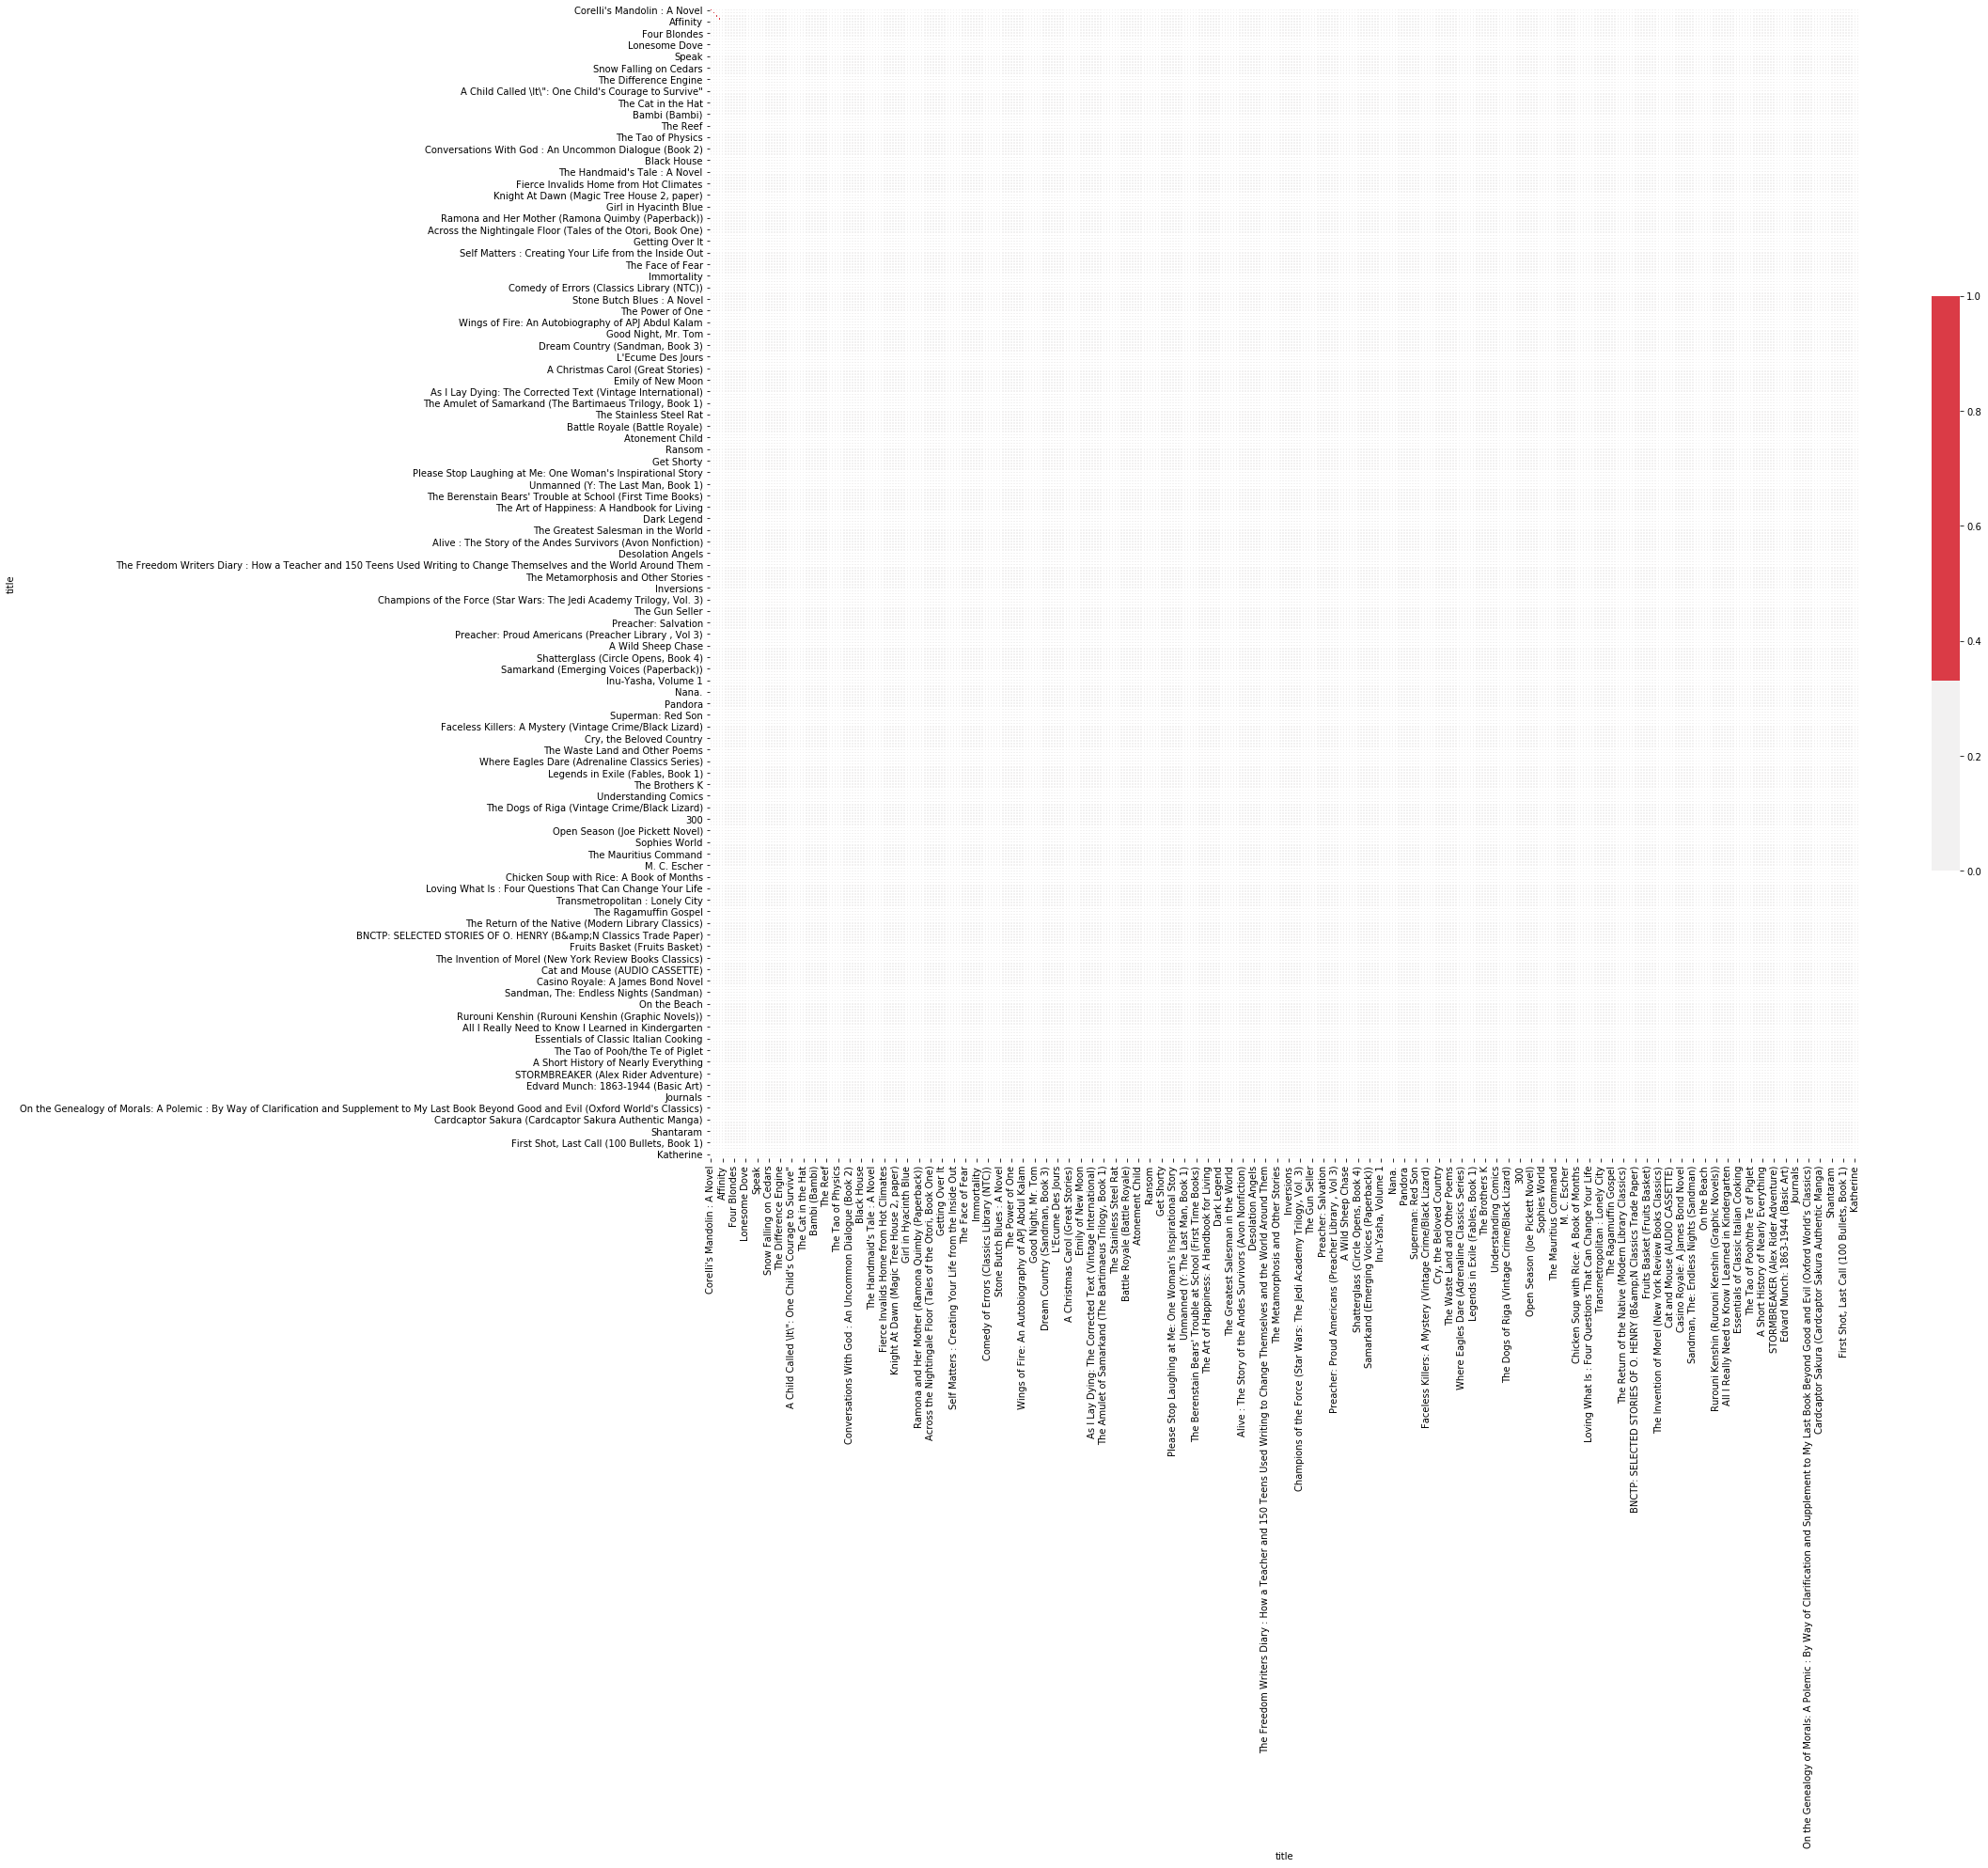

In [111]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(27.5, 22.5))

cmap =sns.diverging_palette(200, 10, n=3)
#cmap=sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(combined_title_auth_pub_tagSim, 
            cmap=cmap,
            center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

f.savefig('combined_title_auth_pub_tagSim.png')

## check recommended results with dataset

In [55]:
df_ratings = df_ratings.merge(df_books, on='isbn')[['uid', 'isbn', 'rating', 'title']]

In [56]:
df_ratings[df_ratings['isbn']=='006441034X']

,uid,isbn,rating,title
9842,15670,006441034X,8,Howl's Moving Castle
9843,26621,006441034X,8,Howl's Moving Castle
9844,49889,006441034X,9,Howl's Moving Castle
9845,87938,006441034X,8,Howl's Moving Castle
9846,102642,006441034X,4,Howl's Moving Castle
9847,111174,006441034X,0,Howl's Moving Castle
9848,203910,006441034X,10,Howl's Moving Castle
9849,252953,006441034X,9,Howl's Moving Castle
9850,264312,006441034X,10,Howl's Moving Castle


In [57]:
df_ratings[df_ratings['uid']==111174]

,uid,isbn,rating,title
753,111174,014023313X,0,The Stone Diaries
2663,111174,067976402X,0,Snow Falling on Cedars
4876,111174,1576737330,0,The Prayer of Jabez: Breaking Through to the B...
6123,111174,038531258X,0,Cold Sassy Tree
6246,111174,037570504X,0,"Breath, Eyes, Memory"
7803,111174,031242227X,0,Running with Scissors: A Memoir
8666,111174,038070952X,0,Ramona and Her Mother (Ramona Quimby (Paperback))
9246,111174,038000321X,0,Alive : The Story of the Andes Survivors (Avon...
9677,111174,1878424114,0,The Seven Spiritual Laws of Success: A Practic...
9847,111174,006441034X,0,Howl's Moving Castle


In [58]:
bought = list(df_ratings[df_ratings['uid']==111174]['title'])

In [59]:
titles = list(titles_recom('Howl\'s Moving Castle', 10))
authors = list(authors_recom('Howl\'s Moving Castle', 10))
pubs = list(pubs_recom('Howl\'s Moving Castle', 10))
tags = list(tags_recom('Howl\'s Moving Castle', 10))

In [60]:
combined_title_tag = list(combined_title_tag_recom('Howl\'s Moving Castle', 10))
combined_auth_tag = list(combined_auth_tag_recom('Howl\'s Moving Castle', 10))
combined_pub_tag = list(combined_pub_tag_recom('Howl\'s Moving Castle', 10))
combined_title_auth_pub_tag = list(combined_title_auth_pub_tag_recom('Howl\'s Moving Castle', 10))

In [61]:
set(bought).intersection(set(titles))

set()

In [62]:
set(bought).intersection(set(authors))

set()

In [63]:
set(bought).intersection(set(pubs))

{"Howl's Moving Castle", 'Ramona and Her Mother (Ramona Quimby (Paperback))'}

In [64]:
set(bought).intersection(set(combined_title_tag))

set()

In [65]:
set(bought).intersection(set(combined_auth_tag))

{'Alive : The Story of the Andes Survivors (Avon Nonfiction)'}

In [66]:
set(bought).intersection(set(combined_pub_tag))

{"Howl's Moving Castle"}

In [67]:
set(bought).intersection(set(combined_title_auth_pub_tag))

{'Alive : The Story of the Andes Survivors (Avon Nonfiction)',
 'Ramona and Her Mother (Ramona Quimby (Paperback))'}

Becuase the dataset with book tags didn't have that much overlap with our dataset, our dataset became really small and calculating recommendation accuracy became really difficult.

However, from a quick glance checking with a user who bought a lot of books, we see that there are some overlaps between what the user actually bought and our recommendation based on similarity of different book features. There are more combinations and possibilities that we can try with text data of book features. 

It is important to note that book features such as title, publisher, and author name are from the book itself, as well as other features that were not available in our dataset, such as book genre, book description etc. While other features, such as book tags or book reviews, are user input.

It is also interesting to see how book features and features from users can interact together and affect the similarity between books and further affect the recommendation accuracy. 